In [ ]:
!pip install spark-nlp

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


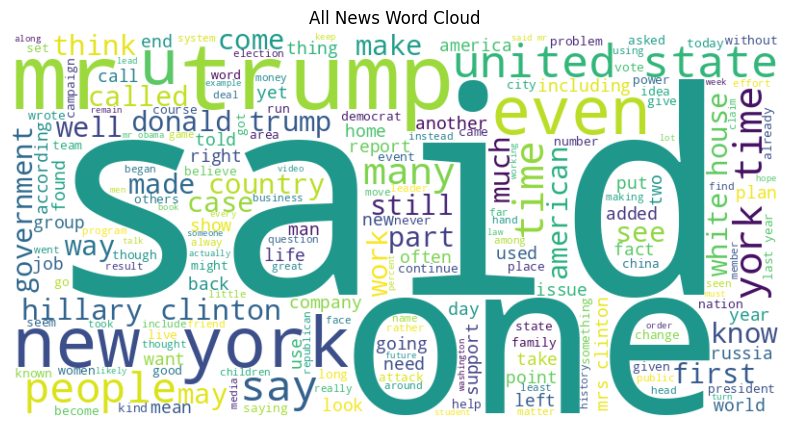

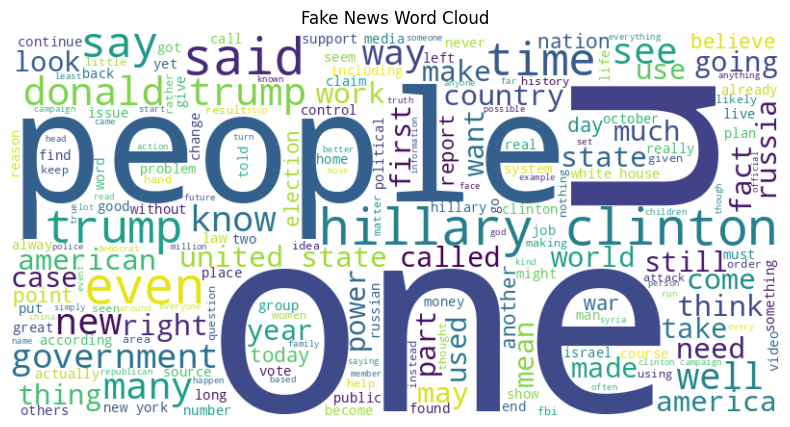

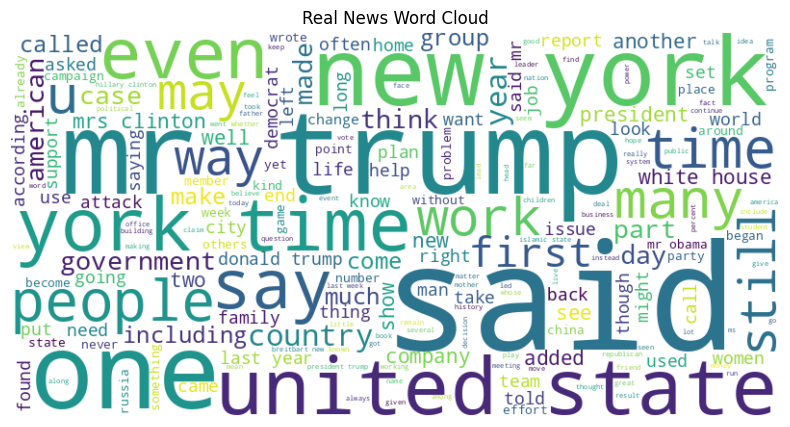

In [ ]:
# Fake News Detection Using PySpark, Spark NLP, and Deep Learning

# ================================
# 1. SETUP
# ================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sparknlp
from pyspark.sql import SparkSession
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from wordcloud import WordCloud

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re

# Start Spark Session
spark = sparknlp.start()

# ================================
# 2. LOAD DATA
# ================================

df_pd = pd.read_csv("train.csv")
df_pd = df_pd.dropna()
df_pd['content'] = df_pd['author'] + ' ' + df_pd['title'] + ' ' + df_pd['text']
df_pd = df_pd[['content', 'label']]

# For EDA, use pandas
# ================================
# 3. EDA
# ================================

def clean_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.lower()
    text = text.split()
    text = [word for word in text if word not in stopwords.words('english')]
    return " ".join(text)

df_pd['cleaned'] = df_pd['content'].apply(clean_text)

def plot_wordcloud(texts, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(texts))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

plot_wordcloud(df_pd['cleaned'], 'All News Word Cloud')
plot_wordcloud(df_pd[df_pd['label'] == 1]['cleaned'], 'Fake News Word Cloud')
plot_wordcloud(df_pd[df_pd['label'] == 0]['cleaned'], 'Real News Word Cloud')



In [ ]:
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline

# Document Assembler
document_assembler = DocumentAssembler() \
    .setInputCol("content") \
    .setOutputCol("document")

# Tokenizer
tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

# Clean tokens
normalizer = Normalizer() \
    .setInputCols(["token"]) \
    .setOutputCol("normalized")

stopwords_cleaner = StopWordsCleaner() \
    .setInputCols(["normalized"]) \
    .setOutputCol("cleanTokens") \
    .setCaseSensitive(False)

# ✅ Use sentence embeddings (e.g., from Universal Sentence Encoder)
use_embeddings = UniversalSentenceEncoder.pretrained(name="tfhub_use", lang="en") \
    .setInputCols(["document"]) \
    .setOutputCol("sentence_embeddings")

# ✅ ClassifierDL expects sentence_embeddings as input
classifier = ClassifierDLModel.pretrained("classifierdl_use_trec6", "en") \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("class")

# Assemble the pipeline
pipeline = Pipeline(stages=[
    document_assembler,
    tokenizer,
    normalizer,
    stopwords_cleaner,
    use_embeddings,
    classifier
])


tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
classifierdl_use_trec6 download started this may take some time.
Approximate size to download 21.4 MB
[OK!]


In [ ]:
# Fit the pipeline
model = pipeline.fit(df_spark)

# Transform to get embeddings
result = model.transform(df_spark)

# Select embeddings and labels
embedding_df = result.select("sentence_embeddings.embeddings", "label")


In [ ]:
import numpy as np
import pandas as pd

# Convert to Pandas
embed_pd = embedding_df.toPandas()

# Convert embeddings column to numpy arrays
X = np.array(embed_pd["embeddings"].tolist())  # Shape: (n_samples, 1, 512)
y = embed_pd["label"].values


In [ ]:
from sklearn.model_selection import train_test_split

# Squeeze the embeddings to remove 1-d dim: (n, 1, 512) -> (n, 512)
X = np.squeeze(X)

# Reshape for LSTM: (samples, timesteps, features)
X = X.reshape((X.shape[0], 1, X.shape[1]))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7043 - loss: 0.5574 - val_accuracy: 0.8465 - val_loss: 0.3534
Epoch 2/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8583 - loss: 0.3368 - val_accuracy: 0.8643 - val_loss: 0.3218
Epoch 3/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8665 - loss: 0.3153 - val_accuracy: 0.8735 - val_loss: 0.3022
Epoch 4/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8753 - loss: 0.3008 - val_accuracy: 0.8753 - val_loss: 0.2959
Epoch 5/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8760 - loss: 0.2896 - val_accuracy: 0.8753 - val_loss: 0.2853
Epoch 6/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8830 - loss: 0.2903 - val_accuracy: 0.8817 - val_loss: 0.2814
Epoch 7/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8902 - loss: 0.2688 - val_accuracy: 0.8804 - val_loss: 0.2784
Epoch 8/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8861 - loss: 0.2749 - val_accuracy: 

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")


115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8893 - loss: 0.2726
Test Accuracy: 0.89


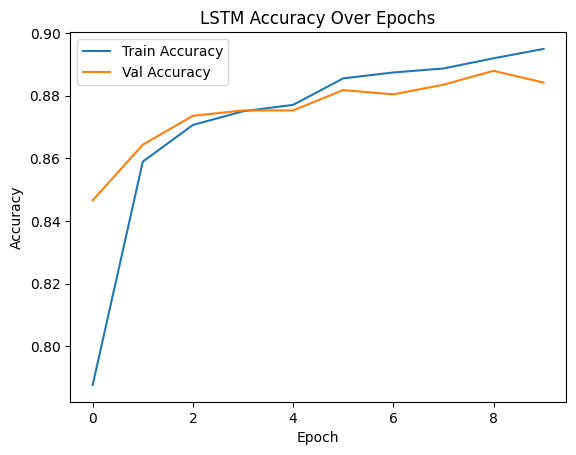

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("LSTM Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
